<a href="https://colab.research.google.com/github/Ankit-521/Machine-Learning-Projects/blob/main/Twitter_Sentiment_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing important library

In [1]:
pip install transformers

     |████████████████████████████████| 2.3MB 7.8MB/s 
     |████████████████████████████████| 3.3MB 35.1MB/s 
     |████████████████████████████████| 901kB 50.9MB/s 


In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.model_selection import StratifiedKFold
import transformers 
import tokenizers
print('TF version',tf.__version__)

TF version 2.4.1


# Upload dataset

In [3]:

from google.colab import files
uploaded=files.upload()

for fn in uploaded.keys():
  print("your uploaded file {name} with length of file{len}".format(name=fn,len=len(uploaded[fn])))

Saving test.csv to test.csv
Saving train.csv to train.csv
your uploaded file test.csv with length of file313984
your uploaded file train.csv with length of file3501243


# Data exploration

In [4]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [5]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [6]:
train.describe()

,textID,text,selected_text,sentiment
count,27481,27480,27480,27481
unique,27481,27480,22463,3
top,1e87921e6f,"Umm. What do we have here? Apple pie, check. C...",good,neutral
freq,1,1,199,11118


In [7]:
train=train.fillna('')

In [8]:
train['length'] = train['text'].apply(len)
train.head()

,textID,text,selected_text,sentiment,length
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,36
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,46
2,088c60f138,my boss is bullying me...,bullying me,negative,25
3,9642c003ef,what interview! leave me alone,leave me alone,negative,31
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,75


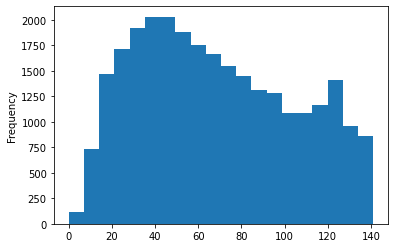

In [9]:
train['length'].plot(bins=20,kind='hist')

In [10]:
# roberta tokenizera is preferred
tokenizer = transformers.RobertaTokenizer.from_pretrained('roberta-base')

# Data preparation

In [11]:
# token of " positive negative neutral"
tokens_pt = tokenizer(" negative positive neutral")
for key, value in tokens_pt.items():
    print("{}:\n\t{}".format(key, value))

input_ids:
	[0, 2430, 1313, 7974, 2]
attention_mask:
	[1, 1, 1, 1, 1]


In [12]:
sentiment_id = {'positive': 1313, 'negative': 2430, 'neutral': 7974}

In [13]:
# function for preprocessing data for desirable format
MAX_LEN=96
ct = train.shape[0]
input_ids = np.ones((ct,MAX_LEN),dtype='int32')
attention_mask = np.zeros((ct,MAX_LEN),dtype='int32')
start_tokens = np.zeros((ct,MAX_LEN),dtype='int32') # start of output
end_tokens = np.zeros((ct,MAX_LEN),dtype='int32')  # end of output

for k in range(train.shape[0]):
    
    # FIND OVERLAP
    text1 = " "+" ".join(train.loc[k,'text'].split())
    text2 = " ".join(train.loc[k,'selected_text'].split())
    idx = text1.find(text2)
    chars = np.zeros((len(text1)))
    chars[idx:idx+len(text2)]=1
    if text1[idx-1]==' ': chars[idx-1] = 1 
    enc = tokenizer.encode(text1) 
        
    # ID_OFFSETS
    offsets = []; idx=0
    for t in enc:#.ids:
        w = tokenizer.decode([t])
        offsets.append((idx,idx+len(w)))
        idx += len(w)
    
    # START END TOKENS
    toks = []
    for i,(a,b) in enumerate(offsets):
        sm = np.sum(chars[a:b])
        if sm>0: toks.append(i) 
        
    s_tok = sentiment_id[train.loc[k,'sentiment']]
    input_ids[k,:len(enc)+5] = [0] + enc + [2,2] + [s_tok] + [2]
    attention_mask[k,:len(enc)+5] = 1
    if len(toks)>0:
        start_tokens[k,toks[0]+1] = 1
        end_tokens[k,toks[-1]+1] = 1

# Testing data preparation

In [14]:
ct = test.shape[0]
input_ids_t = np.ones((ct,MAX_LEN),dtype='int32')
attention_mask_t = np.zeros((ct,MAX_LEN),dtype='int32')
for k in range(test.shape[0]):
        
    # INPUT_IDS
    text1 = " "+" ".join(test.loc[k,'text'].split())
    enc = tokenizer.encode(text1)                
    s_tok = sentiment_id[test.loc[k,'sentiment']]
    input_ids_t[k,:len(enc)+5] = [0] + enc + [2,2] + [s_tok] + [2]
    attention_mask_t[k,:len(enc)+5] = 1

# Model Preparation

In [15]:
def build_model():
    ids = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    att = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    bert_model = transformers.TFRobertaModel.from_pretrained('roberta-base')
    x = bert_model(ids,attention_mask=att)
    
    x1 = tf.keras.layers.Dropout(0.1)(x[0]) 
    x1 = tf.keras.layers.Conv1D(1,1)(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Activation('softmax')(x1)
    
    x2 = tf.keras.layers.Dropout(0.1)(x[0]) 
    x2 = tf.keras.layers.Conv1D(1,1)(x2)
    x2 = tf.keras.layers.Flatten()(x2)
    x2 = tf.keras.layers.Activation('softmax')(x2)

    model = tf.keras.models.Model(inputs=[ids, att], outputs=[x1,x2])
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer)

    return model

In [16]:
# metric
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    if (len(a)==0) & (len(b)==0): return 0.5
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

# Model Training

In [17]:
jac = []; VER='v0'; DISPLAY=1 # USE display=1 FOR INTERACTIVE
oof_start = np.zeros((input_ids.shape[0],MAX_LEN))
oof_end = np.zeros((input_ids.shape[0],MAX_LEN))
preds_start = np.zeros((input_ids_t.shape[0],MAX_LEN))
preds_end = np.zeros((input_ids_t.shape[0],MAX_LEN))

skf = StratifiedKFold(n_splits=5,shuffle=True,random_state=777)
for fold,(idxT,idxV) in enumerate(skf.split(input_ids,train.sentiment.values)):

    print('#'*20)
    print('### FOLD %i'%(fold+1))
    print('#'*20)
    
    K.clear_session()
    model = build_model()
        
    sv = tf.keras.callbacks.ModelCheckpoint(
        '%s-roberta-%i.h5'%(VER,fold), monitor='val_loss', verbose=1, save_best_only=True,
        save_weights_only=True, mode='auto', save_freq='epoch')
        
    model.fit([input_ids[idxT,], attention_mask[idxT,]], [start_tokens[idxT,], end_tokens[idxT,]], 
        epochs=2, batch_size=32, verbose=DISPLAY, callbacks=[sv],
        validation_data=([input_ids[idxV,],attention_mask[idxV,]], 
        [start_tokens[idxV,], end_tokens[idxV,]]))
    
    print('Loading model...')
    model.load_weights('%s-roberta-%i.h5'%(VER,fold))
    
    print('Predicting OOF...')
    oof_start[idxV,],oof_end[idxV,] = model.predict([input_ids[idxV,],attention_mask[idxV,]],verbose=DISPLAY)
    
    print('Predicting Test...')
    preds = model.predict([input_ids_t,attention_mask_t],verbose=DISPLAY)
    preds_start += preds[0]/skf.n_splits
    preds_end += preds[1]/skf.n_splits
    
    # DISPLAY FOLD JACCARD
    all = []
    for k in idxV:
        a = np.argmax(oof_start[k,])
        b = np.argmax(oof_end[k,])
        if a>b: 
            st = train.loc[k,'text'] # IMPROVE CV/LB with better choice here
        else:
            text1 = " "+" ".join(train.loc[k,'text'].split())
            enc = tokenizer.encode(text1)
            st = tokenizer.decode(enc[a-1:b])
        all.append(jaccard(st,train.loc[k,'selected_text']))
    jac.append(np.mean(all))
    print('>>>> FOLD %i Jaccard ='%(fold+1),np.mean(all))
    print()

####################
### FOLD 1
####################


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/2
688/688 [==============================] - 489s 690ms/step - loss: 2.8283 - activation_loss: 1.4440 - activation_1_loss: 1.3842 - val_loss: 1.6565 - val_activation_loss: 0.8380 - val_activation_1_loss: 0.8185

Epoch 00001: val_loss improved from inf to 1.65646, saving model to v0-roberta-1.h5
Epoch 2/2
688/688 [==============================] - 474s 690ms/step - loss: 1.5425 - activation_loss: 0.7814 - activation_1_loss: 0.7612 - val_loss: 1.5196 - val_activation_loss: 0.7566 - val_activation_1_loss: 0.7630

Epoch 00002: val_loss improved from 1.65646 to 1.51965, saving model to v0-roberta-1.h5
Loading model...
Predicting OOF...
172/172 [==============================] - 37s 199ms/step
Predicting Test...
111/111 [==============================] - 22s 199ms/step
>>>> FOLD 2 Jaccard = 0.4944930520579036

####################
### FOLD 3
####################


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/2
688/688 [==============================] - 488s 688ms/step - loss: 2.9367 - activation_loss: 1.5192 - activation_1_loss: 1.4175 - val_loss: 1.6199 - val_activation_loss: 0.8234 - val_activation_1_loss: 0.7965

Epoch 00001: val_loss improved from inf to 1.61991, saving model to v0-roberta-2.h5
Epoch 2/2
688/688 [==============================] - 479s 696ms/step - loss: 1.5467 - activation_loss: 0.7802 - activation_1_loss: 0.7665 - val_loss: 1.5313 - val_activation_loss: 0.7565 - val_activation_1_loss: 0.7748

Epoch 00002: val_loss improved from 1.61991 to 1.53130, saving model to v0-roberta-2.h5
Loading model...
Predicting OOF...
172/172 [==============================] - 37s 202ms/step
Predicting Test...
111/111 [==============================] - 22s 202ms/step
>>>> FOLD 3 Jaccard = 0.5007426602263305

####################
### FOLD 4
####################


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/2
688/688 [==============================] - 493s 696ms/step - loss: 3.0601 - activation_loss: 1.6901 - activation_1_loss: 1.3700 - val_loss: 1.6160 - val_activation_loss: 0.7992 - val_activation_1_loss: 0.8169

Epoch 00001: val_loss improved from inf to 1.61603, saving model to v0-roberta-3.h5
Epoch 2/2
688/688 [==============================] - 479s 696ms/step - loss: 1.5555 - activation_loss: 0.7823 - activation_1_loss: 0.7732 - val_loss: 1.5153 - val_activation_loss: 0.7601 - val_activation_1_loss: 0.7552

Epoch 00002: val_loss improved from 1.61603 to 1.51534, saving model to v0-roberta-3.h5
Loading model...
Predicting OOF...
172/172 [==============================] - 37s 200ms/step
Predicting Test...
111/111 [==============================] - 22s 200ms/step
>>>> FOLD 4 Jaccard = 0.502571754680484

####################
### FOLD 5
####################


Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/2
688/688 [==============================] - 491s 692ms/step - loss: 2.8350 - activation_loss: 1.4634 - activation_1_loss: 1.3716 - val_loss: 1.5704 - val_activation_loss: 0.8019 - val_activation_1_loss: 0.7686

Epoch 00001: val_loss improved from inf to 1.57044, saving model to v0-roberta-4.h5
Epoch 2/2
688/688 [==============================] - 482s 701ms/step - loss: 1.5369 - activation_loss: 0.7771 - activation_1_loss: 0.7598 - val_loss: 1.5026 - val_activation_loss: 0.7590 - val_activation_1_loss: 0.7436

Epoch 00002: val_loss improved from 1.57044 to 1.50262, saving model to v0-roberta-4.h5
Loading model...
Predicting OOF...
172/172 [==============================] - 37s 202ms/step
Predicting Test...
111/111 [==============================] - 22s 202ms/step
>>>> FOLD 5 Jaccard = 0.5116216695509205



In [18]:
result = []
for k in range(input_ids_t.shape[0]):
    a = np.argmax(preds_start[k,])
    b = np.argmax(preds_end[k,])
    if a>b: 
        st = test.loc[k,'text']
    else:
        text1 = " "+" ".join(test.loc[k,'text'].split())
        enc = tokenizer.encode(text1)
        st = tokenizer.decode(enc[a-1:b])
    result.append(st)

In [19]:
test['selected_text'] = result
test[['textID','selected_text']].to_csv('submission.csv',index=False)
pd.set_option('max_colwidth', 60)
test.sample(25)

,textID,text,sentiment,selected_text
2496,88ea8d1421,"thelma & louise, Good movie.",positive,"ise, Good movie"
1980,587cf8a61e,it is my honor,positive,my honor
1251,ef465b57eb,sounds awesome..,positive,<s> sounds awesome
3089,0c0d180b5c,Thanks. Appreciate it.,positive,<s> Thanks
2536,484373037f,I`ll be at the new movie showing at the franklin on Thu...,neutral,<s> I`ll be at the new movie showing at the franklin on ...
3012,9f89432794,"Well, looks like it is going to be another night without...",negative,bug Missing
1516,e32bcc9304,http://skipall.com/8p.png The come apart easy enough,positive,apart easy enough
927,d3e52b51b7,Its WoW! effect Thanks for the update.,positive,effect Thanks
786,264f1af9a0,"english screwed up my overall percentage in X, in XII a...",negative,english screwed
732,9b172f1737,gawd. People still remember the preggers comment. Hate ...,negative,comment. Hate you
